**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
import os
import cv2
import numpy as np

import albumentations as A
import tqdm
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


In [3]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform, aug=None,):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
        
        if self.aug:
            sample = self.aug(
                image=image,
                mask=mask,
            )
        else:
            sample = {
                'image': image,
                'mask': mask,
            }
        
        sample['image'] = self.transform(sample['image']).float()
        sample['image'] = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(sample['image'])
        
        sample['mask'] = self.transform(sample['mask']).float()
        return sample

In [4]:
X_train = get_paths("data/train/images")
y_train = get_paths("data/train/gt")
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomCrop(368, 368),
    A.Resize(370, 370),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.RGBShift(r_shift_limit=10/255, g_shift_limit=10/255, b_shift_limit=10/255, p=0.5),
])

train_transform = transforms.Compose([
    transforms.ToTensor(),
])


X_test = get_paths("data/test/images")
y_test = get_paths("data/test/gt")
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [5]:
train_dataset = RoadDataset(X_train, y_train, train_transform, aug=train_aug)
test_dataset = RoadDataset(X_test, y_test, test_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


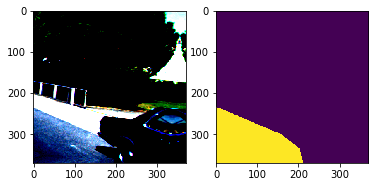

In [6]:
sample = train_dataset[4]
image = sample['image']
mask = sample['mask']

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask.permute(1, 2, 0)[...,0])

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [7]:
print(f"Train Dataset length {len(train_dataset)}")
print(f"Test Dataset length {len(test_dataset)}")

Train Dataset length 648
Test Dataset length 219


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

In [8]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection)/union

In [9]:
def central_crop(images, size):
    current_size = images.size(2)
    border_len = (current_size - size) // 2
    images = images[:, :, border_len:current_size-border_len, border_len:current_size-border_len]
    return images

In [10]:
import numpy as np
import time


def eval_model(model, data_generator):
    predictions = []
    true_masks = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for sample in data_generator:
            X_batch = sample['image']
            y_batch = sample['mask']
            X_batch = F.pad(X_batch, ((376-370) // 2, (376-370) // 2, (376-370) // 2, (376-370) // 2), 
                            "constant", 0)
            
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            logits = central_crop(logits, 370)
            y_pred = logits.max(1)[1].data
            predictions.append(y_pred.cpu())
            true_masks.append(y_batch.cpu())
    predictions = torch.cat(predictions, dim=0)
    true_masks = torch.cat(true_masks, dim=0)
    return calc_iou(predictions.numpy(), true_masks.numpy())

            
def train_model(model, optimizer, train_data_generator):
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.4, 0.6])).to(device)
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for sample in tqdm.tqdm(train_data_generator):
        X_batch = sample['image']
        y_batch = sample['mask']
        X_batch = F.pad(X_batch, ((376-370) // 2, (376-370) // 2, (376-370) // 2, (376-370) // 2), 
                        "constant", 0)
        
        X_batch = X_batch.to(device)
        y_batch = torch.squeeze(y_batch, 1).to(device, dtype=torch.long) 
        predictions = central_crop(model(X_batch), 370)
        
        loss = criterion(predictions, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, optimizer, train_data_generator, val_data_generator, 
               epochs_for_lr_decay=[], num_epochs=1):
    """
    num_epochs - total amount of full passes over training data
    """
    for epoch in range(num_epochs):
        start_time = time.time()
        
        if epoch in epochs_for_lr_decay:
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] / 10
        
        train_loss = train_model(model, optimizer, train_data_generator)  
        val_accuracy = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation iou: \t\t\t{:.3f} ".format(val_accuracy))

In [11]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class=2):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 16)
        self.dconv_down2 = double_conv(16, 32)
        self.dconv_down3 = double_conv(32, 64)
        self.dconv_down4 = double_conv(64, 128)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(64 + 128, 64)
        self.dconv_up2 = double_conv(32 + 64, 32)
        self.dconv_up1 = double_conv(32 + 16, 16)
        
        self.conv_last = nn.Conv2d(16, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

# Training UNET from scratch

In [12]:
unet = UNet().to(device)
optimizer = torch.optim.Adam(unet.parameters(), weight_decay=1e-5)

batch_size = 12
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=4)

test_batch_gen = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=4)

In [13]:
train_loop(unet, optimizer, train_batch_gen, test_batch_gen, epochs_for_lr_decay=[20, 30], num_epochs=40)

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1 of 40 took 58.451s
  training loss (in-iteration): 	0.379643
  validation iou: 			0.622 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2 of 40 took 46.757s
  training loss (in-iteration): 	0.280173
  validation iou: 			0.583 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3 of 40 took 46.029s
  training loss (in-iteration): 	0.251171
  validation iou: 			0.648 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4 of 40 took 44.837s
  training loss (in-iteration): 	0.226307
  validation iou: 			0.664 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5 of 40 took 45.194s
  training loss (in-iteration): 	0.216606
  validation iou: 			0.663 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6 of 40 took 45.142s
  training loss (in-iteration): 	0.205887
  validation iou: 			0.682 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7 of 40 took 45.142s
  training loss (in-iteration): 	0.204979
  validation iou: 			0.691 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8 of 40 took 45.173s
  training loss (in-iteration): 	0.197714
  validation iou: 			0.675 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9 of 40 took 45.498s
  training loss (in-iteration): 	0.189428
  validation iou: 			0.685 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10 of 40 took 45.428s
  training loss (in-iteration): 	0.181262
  validation iou: 			0.705 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 11 of 40 took 45.291s
  training loss (in-iteration): 	0.183367
  validation iou: 			0.673 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 12 of 40 took 46.926s
  training loss (in-iteration): 	0.189660
  validation iou: 			0.731 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 13 of 40 took 46.431s
  training loss (in-iteration): 	0.173707
  validation iou: 			0.724 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 14 of 40 took 45.374s
  training loss (in-iteration): 	0.170385
  validation iou: 			0.725 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 15 of 40 took 45.427s
  training loss (in-iteration): 	0.170893
  validation iou: 			0.745 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 16 of 40 took 45.779s
  training loss (in-iteration): 	0.174913
  validation iou: 			0.729 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 17 of 40 took 45.677s
  training loss (in-iteration): 	0.167437
  validation iou: 			0.741 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 18 of 40 took 45.812s
  training loss (in-iteration): 	0.162057
  validation iou: 			0.737 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 19 of 40 took 45.914s
  training loss (in-iteration): 	0.156819
  validation iou: 			0.744 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 20 of 40 took 46.539s
  training loss (in-iteration): 	0.151409
  validation iou: 			0.780 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 21 of 40 took 48.323s
  training loss (in-iteration): 	0.135898
  validation iou: 			0.789 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 22 of 40 took 47.260s
  training loss (in-iteration): 	0.130376
  validation iou: 			0.790 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 23 of 40 took 46.253s
  training loss (in-iteration): 	0.124368
  validation iou: 			0.796 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 24 of 40 took 46.877s
  training loss (in-iteration): 	0.128256
  validation iou: 			0.796 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 25 of 40 took 45.857s
  training loss (in-iteration): 	0.122302
  validation iou: 			0.795 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 26 of 40 took 45.518s
  training loss (in-iteration): 	0.128586
  validation iou: 			0.806 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 27 of 40 took 45.580s
  training loss (in-iteration): 	0.122095
  validation iou: 			0.803 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 28 of 40 took 45.836s
  training loss (in-iteration): 	0.120932
  validation iou: 			0.800 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 29 of 40 took 45.781s
  training loss (in-iteration): 	0.121320
  validation iou: 			0.804 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 30 of 40 took 45.760s
  training loss (in-iteration): 	0.118078
  validation iou: 			0.807 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 31 of 40 took 45.516s
  training loss (in-iteration): 	0.117716
  validation iou: 			0.807 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 32 of 40 took 45.396s
  training loss (in-iteration): 	0.112945
  validation iou: 			0.811 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 33 of 40 took 45.337s
  training loss (in-iteration): 	0.117429
  validation iou: 			0.810 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 34 of 40 took 45.438s
  training loss (in-iteration): 	0.112084
  validation iou: 			0.809 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 35 of 40 took 45.593s
  training loss (in-iteration): 	0.116588
  validation iou: 			0.810 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 36 of 40 took 46.647s
  training loss (in-iteration): 	0.113977
  validation iou: 			0.810 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 37 of 40 took 46.440s
  training loss (in-iteration): 	0.113315
  validation iou: 			0.810 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 38 of 40 took 46.770s
  training loss (in-iteration): 	0.120886
  validation iou: 			0.811 


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch 39 of 40 took 46.109s
  training loss (in-iteration): 	0.119892
  validation iou: 			0.812 


100%|██████████| 54/54 [00:40<00:00,  1.34it/s]


Epoch 40 of 40 took 45.423s
  training loss (in-iteration): 	0.117563
  validation iou: 			0.810 


In [14]:
val_accuracy = eval_model(unet, test_batch_gen)
print("Final test iou for unet: \t\t\t{:.3f} ".format(val_accuracy))

Final test iou for unet: 			0.810 


# Training using pretrained classifier

Сделаем модель, в которой энкодер - часть предобученного резнета, а декодер состоит из рез-блоков.

In [15]:
class ResNetBlock(nn.Module):
    def __init__(self, ich, outch):
        super().__init__()
        self.conv1 = nn.Conv2d(ich, outch, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(outch)
        self.conv2 = nn.Conv2d(outch, outch, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(outch)
        self.relu = nn.ReLU()
        self.skip = nn.Conv2d(ich, outch, 1)
        
    def forward(self, x):
        skip = self.skip(x)
        x = self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x)))))
        return self.relu(x + skip)
        

class SegResNet(nn.Module):

    def __init__(self, n_class=2):
        super().__init__()
        resnet18 = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(resnet18.conv1,resnet18.bn1, resnet18.relu, 
                        resnet18.maxpool, resnet18.layer1, resnet18.layer2, resnet18.layer3)
                       
        self.upsample = nn.PixelShuffle(2)
        self.res0 = ResNetBlock(256, 256)
        self.res1 = ResNetBlock(64, 128)
        self.res2 = ResNetBlock(32, 128)
        self.res3 = ResNetBlock(32, 128)
        self.res4 = ResNetBlock(32, 16)
        self.conv_last = nn.Conv2d(16, n_class, 1)
        self.decoder = nn.Sequential(self.res0, self.upsample, self.res1, self.upsample, self.res2,
                                     self.upsample, self.res3, self.upsample, self.res4)
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return self.conv_last(x)

In [16]:
torch.cuda.empty_cache()

batch_size = 8
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=4)

test_batch_gen = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=4)

In [17]:
seg_resnet = SegResNet().to(device)
optimizer = torch.optim.Adam([
        {'params': seg_resnet.decoder.parameters()},
        {'params': seg_resnet.conv_last.parameters()},
        {'params': seg_resnet.encoder.parameters(), 'lr': 1e-4}
    ], lr=1e-3, weight_decay=1e-4)

In [18]:
train_loop(seg_resnet, optimizer, train_batch_gen, test_batch_gen, epochs_for_lr_decay=[20,30], num_epochs=40)

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 1 of 40 took 58.649s
  training loss (in-iteration): 	0.270476
  validation iou: 			0.829 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 2 of 40 took 58.911s
  training loss (in-iteration): 	0.122575
  validation iou: 			0.857 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 3 of 40 took 58.478s
  training loss (in-iteration): 	0.088157
  validation iou: 			0.864 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 4 of 40 took 57.895s
  training loss (in-iteration): 	0.084449
  validation iou: 			0.878 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 5 of 40 took 58.791s
  training loss (in-iteration): 	0.073725
  validation iou: 			0.892 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 6 of 40 took 58.336s
  training loss (in-iteration): 	0.071131
  validation iou: 			0.879 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 7 of 40 took 58.330s
  training loss (in-iteration): 	0.056469
  validation iou: 			0.890 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 8 of 40 took 57.939s
  training loss (in-iteration): 	0.055522
  validation iou: 			0.889 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 9 of 40 took 57.792s
  training loss (in-iteration): 	0.055732
  validation iou: 			0.894 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 10 of 40 took 58.139s
  training loss (in-iteration): 	0.055143
  validation iou: 			0.894 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 11 of 40 took 58.994s
  training loss (in-iteration): 	0.048440
  validation iou: 			0.905 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 12 of 40 took 58.474s
  training loss (in-iteration): 	0.042725
  validation iou: 			0.893 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 13 of 40 took 58.114s
  training loss (in-iteration): 	0.044414
  validation iou: 			0.901 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 14 of 40 took 58.382s
  training loss (in-iteration): 	0.039620
  validation iou: 			0.893 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 15 of 40 took 59.525s
  training loss (in-iteration): 	0.041110
  validation iou: 			0.897 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 16 of 40 took 58.710s
  training loss (in-iteration): 	0.038393
  validation iou: 			0.869 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 17 of 40 took 58.351s
  training loss (in-iteration): 	0.037484
  validation iou: 			0.899 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 18 of 40 took 58.854s
  training loss (in-iteration): 	0.038598
  validation iou: 			0.891 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 19 of 40 took 58.981s
  training loss (in-iteration): 	0.035240
  validation iou: 			0.900 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 20 of 40 took 58.411s
  training loss (in-iteration): 	0.030843
  validation iou: 			0.907 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 21 of 40 took 58.286s
  training loss (in-iteration): 	0.028593
  validation iou: 			0.910 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 22 of 40 took 58.603s
  training loss (in-iteration): 	0.027163
  validation iou: 			0.910 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 23 of 40 took 59.053s
  training loss (in-iteration): 	0.026134
  validation iou: 			0.911 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 24 of 40 took 59.639s
  training loss (in-iteration): 	0.025440
  validation iou: 			0.909 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 25 of 40 took 59.051s
  training loss (in-iteration): 	0.024936
  validation iou: 			0.911 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 26 of 40 took 58.964s
  training loss (in-iteration): 	0.025020
  validation iou: 			0.912 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 27 of 40 took 60.057s
  training loss (in-iteration): 	0.023487
  validation iou: 			0.911 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 28 of 40 took 61.450s
  training loss (in-iteration): 	0.024322
  validation iou: 			0.913 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 29 of 40 took 60.087s
  training loss (in-iteration): 	0.024113
  validation iou: 			0.912 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 30 of 40 took 59.120s
  training loss (in-iteration): 	0.023325
  validation iou: 			0.915 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 31 of 40 took 58.571s
  training loss (in-iteration): 	0.023507
  validation iou: 			0.914 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 32 of 40 took 58.608s
  training loss (in-iteration): 	0.022914
  validation iou: 			0.915 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 33 of 40 took 58.888s
  training loss (in-iteration): 	0.022812
  validation iou: 			0.915 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 34 of 40 took 59.006s
  training loss (in-iteration): 	0.022531
  validation iou: 			0.914 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 35 of 40 took 58.602s
  training loss (in-iteration): 	0.022832
  validation iou: 			0.914 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 36 of 40 took 58.795s
  training loss (in-iteration): 	0.022461
  validation iou: 			0.915 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 37 of 40 took 59.498s
  training loss (in-iteration): 	0.023134
  validation iou: 			0.914 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 38 of 40 took 59.902s
  training loss (in-iteration): 	0.021927
  validation iou: 			0.914 


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch 39 of 40 took 59.009s
  training loss (in-iteration): 	0.022471
  validation iou: 			0.915 


100%|██████████| 81/81 [00:51<00:00,  1.57it/s]


Epoch 40 of 40 took 58.672s
  training loss (in-iteration): 	0.022174
  validation iou: 			0.914 


In [19]:
val_accuracy = eval_model(seg_resnet, test_batch_gen)

print("Final test iou for cnn with pretrained classifier: \t\t\t{:.3f} ".format(val_accuracy))

Final test iou for cnn with pretrained classifier: 			0.914 
